In [31]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import f1_score

from sklearn import svm, datasets
from sklearn.metrics import plot_confusion_matrix


import warnings
warnings.filterwarnings('ignore')

print("Important libraries loaded successfully")

Important libraries loaded successfully


In [32]:
data_train = pd.read_csv("data/train.csv")
# data_test = pd.read_csv("data/test.csv")
print("Data shape = ",data_train.shape)
data_train.head(15)

Data shape =  (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


<function matplotlib.pyplot.show(*args, **kw)>

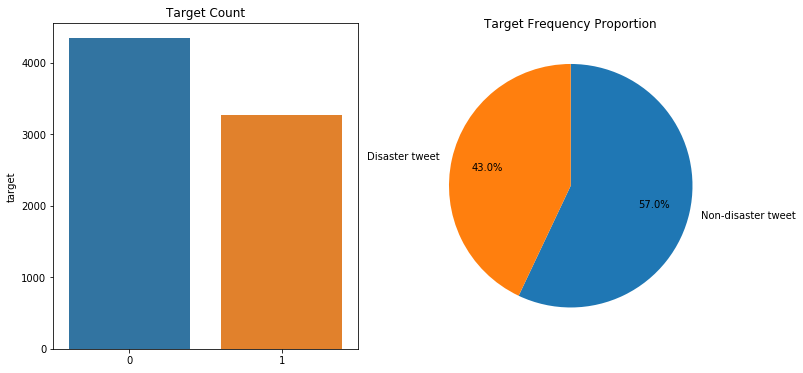

In [33]:
import matplotlib.pyplot as plt
# Target Distribution (0 or 1)
dist_class = data_train['target'].value_counts()
labels = ['Non-disaster tweet', 'Disaster tweet']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

sns.barplot(x=dist_class.index, y=dist_class, ax=ax1).set_title("Target Count")

ax2.pie(dist_class,
        labels=labels,
        counterclock=False,
        startangle=90,
        autopct='%1.1f%%',
        pctdistance=0.7)
plt.title("Target Frequency Proportion")
plt.show

In [34]:
#get total count of data including missing data
total = data_train.isnull().sum().sort_values(ascending=False)
#get percent of missing data relevant to all data
percent = (data_train.isnull().sum()/data_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(data_train.shape[1])

,Total,Percent
location,2533,0.332720
keyword,61,0.008013
target,0,0.000000
text,0,0.000000
id,0,0.000000


In [35]:
data_train = data_train.drop(['location','keyword'], axis=1)
print("location and keyword columns droped successfully")

location and keyword columns droped successfully


In [36]:
data_train = data_train.drop(['id'], axis=1)
print("id droped successfully")

id droped successfully


In [37]:
data_train.columns

Index(['text', 'target'], dtype='object')

In [38]:
data_train["text"].head(10)

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
5    #RockyFire Update => California Hwy. 20 closed...
6    #flood #disaster Heavy rain causes flash flood...
7    I'm on top of the hill and I can see a fire in...
8    There's an emergency evacuation happening now ...
9    I'm afraid that the tornado is coming to our a...
Name: text, dtype: object

In [39]:
corpus  = []
pstem = PorterStemmer()
for i in range(data_train['text'].shape[0]):
    tweet = re.sub("[^a-zA-Z]", ' ', data_train['text'][i])
    tweet = tweet.lower()
    tweet = tweet.split()
    tweet = [pstem.stem(word) for word in tweet if not word in set(stopwords.words('english'))]
    tweet = ' '.join(tweet)
    corpus.append(tweet)  
print("Corpus created successfully")  

Corpus created successfully


In [40]:
print(pd.DataFrame(corpus)[0].head(10))

0            deed reason earthquak may allah forgiv us
1                 forest fire near la rong sask canada
2    resid ask shelter place notifi offic evacu she...
3          peopl receiv wildfir evacu order california
4    got sent photo rubi alaska smoke wildfir pour ...
5    rockyfir updat california hwi close direct due...
6    flood disast heavi rain caus flash flood stree...
7                               top hill see fire wood
8               emerg evacu happen build across street
9                             afraid tornado come area
Name: 0, dtype: object


In [41]:
rawTexData = data_train["text"].head(10)
cleanTexData = pd.DataFrame(corpus, columns=['text after cleaning']).head(10)
frames = [rawTexData, cleanTexData]
result = pd.concat(frames, axis=1, sort=False)
result

,text,text after cleaning
0,Our Deeds are the Reason of this #earthquake M...,deed reason earthquak may allah forgiv us
1,Forest fire near La Ronge Sask. Canada,forest fire near la rong sask canada
2,All residents asked to 'shelter in place' are ...,resid ask shelter place notifi offic evacu she...
3,"13,000 people receive #wildfires evacuation or...",peopl receiv wildfir evacu order california
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo rubi alaska smoke wildfir pour ...
5,#RockyFire Update => California Hwy. 20 closed...,rockyfir updat california hwi close direct due...
6,#flood #disaster Heavy rain causes flash flood...,flood disast heavi rain caus flash flood stree...
7,I'm on top of the hill and I can see a fire in...,top hill see fire wood
8,There's an emergency evacuation happening now ...,emerg evacu happen build across street
9,I'm afraid that the tornado is coming to our a...,afraid tornado come area


In [42]:
#Create our dictionary 
uniqueWordFrequents = {}
for tweet in corpus:
    for word in tweet.split():
        if(word in uniqueWordFrequents.keys()):
            uniqueWordFrequents[word] += 1
        else:
            uniqueWordFrequents[word] = 1
            
#Convert dictionary to dataFrame
uniqueWordFrequents = pd.DataFrame.from_dict(uniqueWordFrequents,orient='index',columns=['Word Frequent'])
uniqueWordFrequents.sort_values(by=['Word Frequent'], inplace=True, ascending=False)
uniqueWordFrequents.head(10)

,Word Frequent
co,4746
http,4721
like,411
fire,363
amp,344
get,311
bomb,239
new,228
via,220
u,216


In [43]:
uniqueWordFrequents['Word Frequent'].unique()

array([4746, 4721,  411,  363,  344,  311,  239,  228,  220,  216,  213,
        210,  209,  201,  183,  181,  180,  178,  175,  169,  166,  164,
        162,  156,  155,  153,  151,  145,  144,  143,  137,  133,  132,
        131,  130,  129,  128,  125,  124,  123,  122,  121,  120,  119,
        118,  117,  116,  114,  111,  110,  109,  108,  106,  105,  104,
        103,  102,  101,  100,   99,   98,   97,   96,   95,   94,   93,
         91,   90,   89,   88,   87,   86,   84,   83,   82,   79,   78,
         77,   76,   75,   74,   73,   72,   71,   70,   69,   68,   67,
         66,   65,   64,   63,   62,   61,   60,   59,   58,   57,   56,
         55,   54,   53,   52,   51,   50,   49,   48,   47,   46,   45,
         44,   43,   42,   41,   40,   39,   38,   37,   36,   35,   34,
         33,   32,   31,   30,   29,   28,   27,   26,   25,   24,   23,
         22,   21,   20,   19,   18,   17,   16,   15,   14,   13,   12,
         11,   10,    9,    8,    7,    6,    5,   

In [44]:
uniqueWordFrequents = uniqueWordFrequents[uniqueWordFrequents['Word Frequent'] >= 20]
print(uniqueWordFrequents.shape)
uniqueWordFrequents

(787, 1)


,Word Frequent
co,4746
http,4721
like,411
fire,363
amp,344
...,...
cnn,20
gem,20
captur,20
arriv,20


In [45]:
# # imports needed and logging
# import gzip
# import gensim 
# import logging
# logging.basicConfig(format= %(asctime)s : %(levelname)s : %(message)s’, level=logging.INFO)
 

In [46]:
counVec = CountVectorizer(max_features = uniqueWordFrequents.shape[0])
bagOfWords = counVec.fit_transform(corpus).toarray()

from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
X= transformer.fit_transform(bagOfWords).toarray()

In [47]:
y = data_train['target']
print("X shape = ",X.shape)
print("y shape = ",y.shape)

X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.20, random_state=55, shuffle =True)
print('data splitting successfully')

X shape =  (7613, 787)
y shape =  (7613,)
data splitting successfully


In [48]:
KNeighborsModel = KNeighborsClassifier(n_neighbors = 7,
                                       weights = 'distance',
                                      algorithm = 'brute')

KNeighborsModel.fit(X_train,y_train)

print("KNeighbors Classifier model run successfully")

KNeighbors Classifier model run successfully


In [49]:
LogisticRegression = LogisticRegression(penalty='l2', 
                                        solver='saga', 
                                        random_state = 55)  

LogisticRegression.fit(X_train,y_train)

print("LogisticRegression Classifier model run successfully")
y_pred = LogisticRegression.predict(X_test)
from sklearn.metrics import confusion_matrix

LogisticRegression Classifier model run successfully


In [50]:
SVClassifier = SVC(kernel= 'linear',
                   degree=3,
                   max_iter=10000,
                   C=2, 
                   random_state = 55)

SVClassifier.fit(X_train,y_train)

print("SVClassifier model run successfully")

SVClassifier model run successfully


In [60]:
bernoulliNBModel = BernoulliNB(alpha=0.1)
bernoulliNBModel.fit(X_train,y_train)

print("bernoulliNB model run successfully")
gaussianNBModel = GaussianNB()
gaussianNBModel.fit(X_train,y_train)

print("gaussianNB model run successfully")
multinomialNBModel = MultinomialNB(alpha=0.1)
multinomialNBModel.fit(X_train,y_train)

print("multinomialNB model run successfully")


bernoulliNB model run successfully
gaussianNB model run successfully
multinomialNB model run successfully


In [61]:
modelsNames = [('LogisticRegression',LogisticRegression),
               ('SVClassifier',SVClassifier),
               ('bernoulliNBModel',bernoulliNBModel),
               ('multinomialNBModel',multinomialNBModel)]

votingClassifier = VotingClassifier(voting = 'hard',estimators= modelsNames)
votingClassifier.fit(X_train,y_train)
print("votingClassifier model run successfully")

votingClassifier model run successfully


In [62]:
type(votingClassifier.fit(X_train,y_train))

sklearn.ensemble._voting.VotingClassifier

KNeighborsClassifier  Train Score is   :  0.9763546798029556
KNeighborsClassifier  Test Score is    :  0.7255416940249507


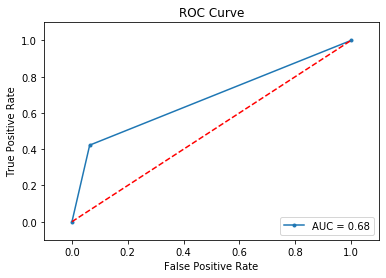

KNeighborsClassifier  F1 Score is      :  0.5581395348837209
KNeighborsClassifier  Classification report  :                precision    recall  f1-score   support

           0       0.70      0.94      0.80       898
           1       0.82      0.42      0.56       625

    accuracy                           0.73      1523
   macro avg       0.76      0.68      0.68      1523
weighted avg       0.75      0.73      0.70      1523

['NON normalized Confusion matrix']
[[841  57]
 [361 264]]


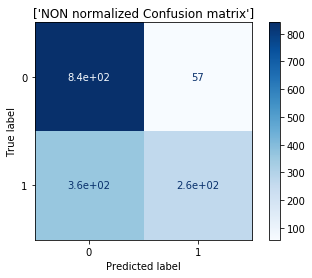

-----------------------------------------------------------------
LogisticRegression  Train Score is   :  0.8264367816091954
LogisticRegression  Test Score is    :  0.7787261982928431


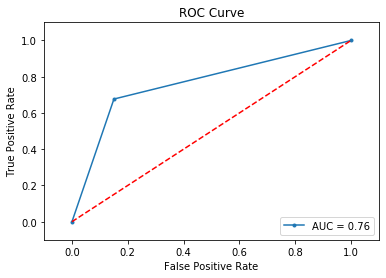

LogisticRegression  F1 Score is      :  0.7151310228233305
LogisticRegression  Classification report  :                precision    recall  f1-score   support

           0       0.79      0.85      0.82       898
           1       0.76      0.68      0.72       625

    accuracy                           0.78      1523
   macro avg       0.77      0.76      0.77      1523
weighted avg       0.78      0.78      0.78      1523

['NON normalized Confusion matrix']
[[763 135]
 [202 423]]


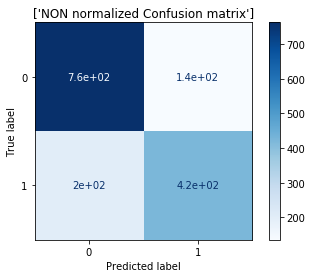

-----------------------------------------------------------------
SVC  Train Score is   :  0.838752052545156
SVC  Test Score is    :  0.7774130006565988


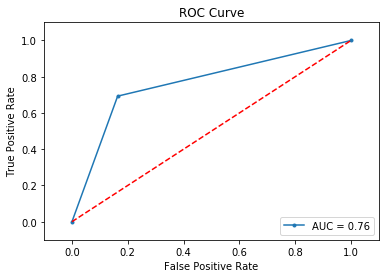

SVC  F1 Score is      :  0.7186721991701245
SVC  Classification report  :                precision    recall  f1-score   support

           0       0.80      0.84      0.82       898
           1       0.75      0.69      0.72       625

    accuracy                           0.78      1523
   macro avg       0.77      0.76      0.77      1523
weighted avg       0.78      0.78      0.78      1523

['NON normalized Confusion matrix']
[[751 147]
 [192 433]]


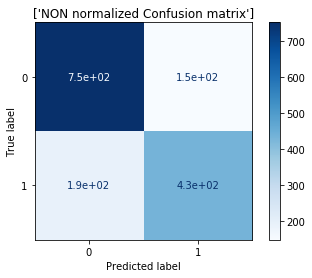

-----------------------------------------------------------------
BernoulliNB  Train Score is   :  0.8091954022988506
BernoulliNB  Test Score is    :  0.7774130006565988


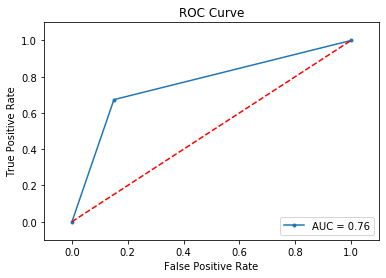

BernoulliNB  F1 Score is      :  0.7129551227773073
BernoulliNB  Classification report  :                precision    recall  f1-score   support

           0       0.79      0.85      0.82       898
           1       0.76      0.67      0.71       625

    accuracy                           0.78      1523
   macro avg       0.77      0.76      0.77      1523
weighted avg       0.78      0.78      0.78      1523

['NON normalized Confusion matrix']
[[763 135]
 [204 421]]


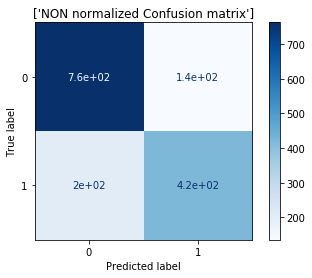

-----------------------------------------------------------------
GaussianNB  Train Score is   :  0.7881773399014779
GaussianNB  Test Score is    :  0.7550886408404465


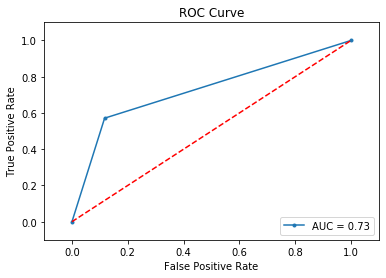

GaussianNB  F1 Score is      :  0.656853725850966
GaussianNB  Classification report  :                precision    recall  f1-score   support

           0       0.75      0.88      0.81       898
           1       0.77      0.57      0.66       625

    accuracy                           0.76      1523
   macro avg       0.76      0.73      0.73      1523
weighted avg       0.76      0.76      0.75      1523

['NON normalized Confusion matrix']
[[793 105]
 [268 357]]


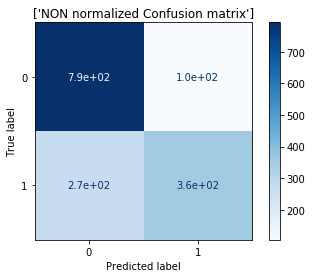

-----------------------------------------------------------------
MultinomialNB  Train Score is   :  0.8072249589490968
MultinomialNB  Test Score is    :  0.7774130006565988


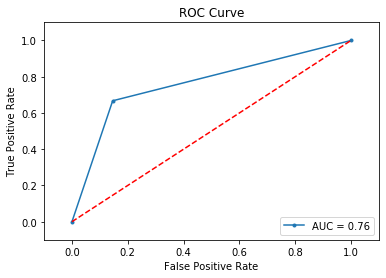

MultinomialNB  F1 Score is      :  0.710997442455243
MultinomialNB  Classification report  :                precision    recall  f1-score   support

           0       0.79      0.85      0.82       898
           1       0.76      0.67      0.71       625

    accuracy                           0.78      1523
   macro avg       0.77      0.76      0.77      1523
weighted avg       0.78      0.78      0.77      1523

['NON normalized Confusion matrix']
[[767 131]
 [208 417]]


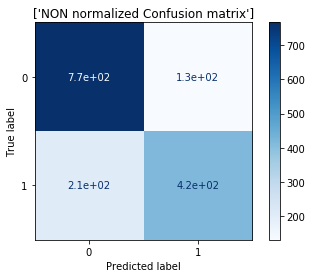

-----------------------------------------------------------------
VotingClassifier  Train Score is   :  0.8257799671592775
VotingClassifier  Test Score is    :  0.7852921864740644


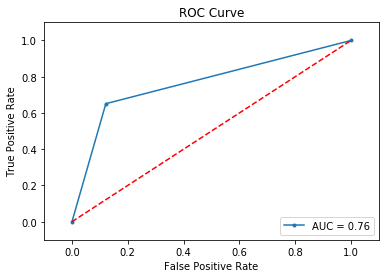

VotingClassifier  F1 Score is      :  0.7134092900964066
VotingClassifier  Classification report  :                precision    recall  f1-score   support

           0       0.78      0.88      0.83       898
           1       0.79      0.65      0.71       625

    accuracy                           0.79      1523
   macro avg       0.79      0.76      0.77      1523
weighted avg       0.79      0.79      0.78      1523

['NON normalized Confusion matrix']
[[789 109]
 [218 407]]


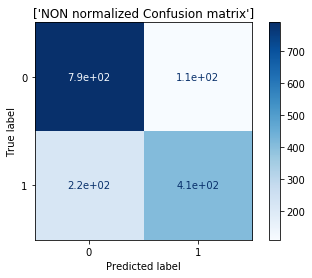

-----------------------------------------------------------------


In [63]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

accurecy_sc = []
objects =[]
#Evaluate Details
models = [ KNeighborsModel, LogisticRegression, 
           SVClassifier, bernoulliNBModel, gaussianNBModel, multinomialNBModel, votingClassifier]

for model in models:
    print(type(model).__name__,' Train Score is   : ' ,model.score(X_train, y_train))
    print(type(model).__name__,' Test Score is    : ' ,model.score(X_test, y_test))
    
    y_pred = model.predict(X_test)
#     roc
#     print(y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc_score = auc(fpr, tpr)
    # clear current figure
    plt.clf()

    plt.title('ROC Curve')
    plt.plot(fpr, tpr, marker='.', label='AUC = {:.2f}'.format(auc_score))
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.show()
      
    accurecy_sc.append(100*model.score(X_test, y_test))
    objects.append(type(model).__name__)

    print(type(model).__name__,' F1 Score is      : ' ,f1_score(y_test,y_pred))
    print (type(model).__name__,' Classification report  : ' ,classification_report(y_test, y_pred))
    #confusion matrix
    title =["NON normalized Confusion matrix"]
    disp = plot_confusion_matrix(model.fit(X_train, y_train), X_test, y_test,
                                     cmap=plt.cm.Blues)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)
    plt.show()
    print('-----------------------------------------------------------------')

In [64]:
import plotly.graph_objects as go

colors = ['crimson']*10 #crimson
fig = go.Figure(data=[go.Bar(
    x=objects,
    y=accurecy_sc,
    marker_color=colors # marker color can be a single color value or an iterable
)])
fig.update_layout(
    title='Machine learning Algorithms:',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Accuracy rate in 100%',
        titlefont_size=16,
        tickfont_size=14,
    ),
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.1 # gap between bars of the same location coordinate.
)

